# Prostate Data

Here we reanalyze the classic example from Efron's papers and books.

In [1]:
using RCall
using Plots
#using StatPlots
using EmpiricalBayes
using Distributions
import Distributions: cf
import EmpiricalBayes: riesz_representer
using KernelDensity
using LaTeXStrings
using JLD
using StatsBase

INFO: Recompiling stale cache file /Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/lib/v0.6/CodecZlib.ji for module CodecZlib.
INFO: Recompiling stale cache file /Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/lib/v0.6/RCall.ji for module RCall.


In [2]:
gr()

Plots.GRBackend()

In [3]:
R"load('datasets/prostz.RData')"
@rget prostz;
Xs = prostz;

In [4]:
hist = fit(Histogram, Xs; nbins=50, closed=:left);

In [5]:
dens = hist.weights/sum(hist.weights)/(step(hist.edges[1]));

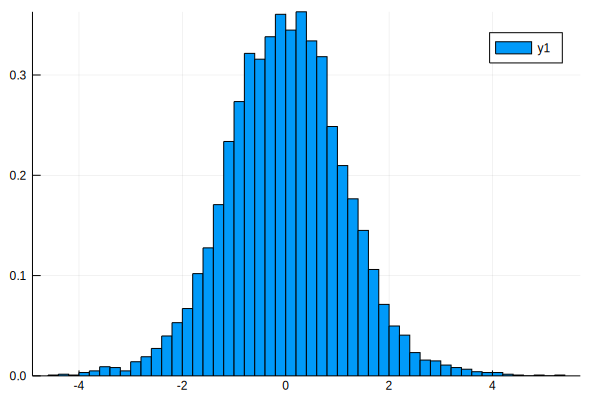

In [6]:
plot(hist.edges, dens, seriestype=:barbins)

Let us use `RCall` to get the z-scores for the prostate data set.

In [12]:
# mynpmle = StatsBase.fit(NPMLE, prior_grid, marginal_grid, prostz; σ=0.0)
# npmle_prob = NormalConvolutionProblem(mynpmle, marginal_grid)


In [8]:
extrema(Xs)

(-4.423917778811027, 5.291963617005193)

In the Biometrika paper, Efron only reports $\Pr[|\mu| \geq 1]$ which is $0.062 \pm 0.014$ and $\Pr[|\mu| \geq 2]$ which is $0.026 \pm 0.002$. Not really purely Empirical Bayes calculations.

Let us use our Basic calibrator for these quantities:

In [9]:
marginal_grid = collect(linspace(-6,6,1001));
prior_grid = collect(linspace(-3,3,121));
marginal_h = marginal_grid[2]-marginal_grid[1];
M_bd = marginal_h/sqrt(2*pi)

#f_const = BinnedMarginalDensity(ones(marginal_grid)*M_bd, marginal_grid, marginal_h);

In [10]:
ds = MixingNormalConvolutionProblem(Normal, 0.2, prior_grid, marginal_grid);
ds_0_5 = MixingNormalConvolutionProblem(Normal, 0.5, prior_grid, marginal_grid);

In [73]:
ds_0_3 = MixingNormalConvolutionProblem(Normal, 0.3, prior_grid, marginal_grid);

# Brown-Greenshtein f-model



In [12]:
x_grid = collect(linspace(-3,3,401))

R"library(splines)"
R"xxmax = 6"
R"xxw = 0.001"
R"xx = seq(-xxmax, xxmax, by = xxw)"
R"HH = hist(prostz, breaks = xx, plot = FALSE)"
R"n=length(prostz)"
R"N = HH$counts"
R"xmids = HH$mids"
R"pois = glm(N ~ ns(x, df = 13), data=data.frame(x=xmids), family = poisson)"
tweedie_f = copy(x_grid)
for (i,x) in enumerate(x_grid)
    R"fhat = predict(pois, newdata = data.frame(x=$(x)+c(-0.001, 0, 0.001)), type = 'response') / n / xxw"
    R"A0 = fhat[2]"
    R"A1 = (fhat[3] - fhat[1]) / 0.002"
    R"pois_posterior = A1/A0"
    @rget pois_posterior
    tweedie_f[i] = x+pois_posterior
end


In [14]:
post_mean_bg = [estimate(Xs, BrownGreenshtein, PosteriorTarget(PosteriorMeanNumerator(x))) for x in x_grid];

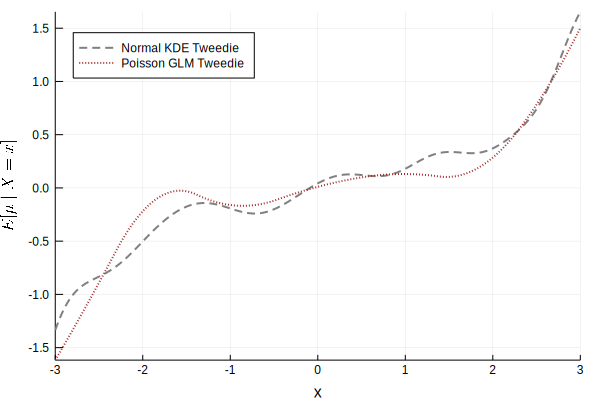

In [15]:
prostate_tweedie = plot(x_grid,  [post_mean_bg tweedie_f] , linewidth=2,
        label =["Normal KDE Tweedie" "Poisson GLM Tweedie"],
        linestyle=[:dash :dot], color=[:grey :brown], legend=:topleft,
        xlabel="x", ylabel=L"E[\mu \mid X=x]")

In [16]:
savefig(prostate_tweedie,"prostate_tweedie.pdf")

# Efron g-model

In [27]:
brad_null =  fit(BradDeconvolveR, Xs, prior_grid=collect(-3.6:0.02:3.6))
brad_non_null =  fit(BradDeconvolveR, Xs, prior_grid=collect(-3.6:0.02:3.6); deltaAt = :nothing, pDegree=10)

EmpiricalBayes.BradDeconvolveR([-3.6, -3.58, -3.56, -3.54, -3.52, -3.5, -3.48, -3.46, -3.44, -3.42  …  3.42, 3.44, 3.46, 3.48, 3.5, 3.52, 3.54, 3.56, 3.58, 3.6], [0.000268691, 0.000254223, 0.000240553, 0.000227654, 0.000215498, 0.000204055, 0.000193297, 0.000183192, 0.000173712, 0.000164827  …  0.000137384, 0.000136955, 0.000136525, 0.000136095, 0.000135665, 0.000135235, 0.000134805, 0.000134376, 0.000133948, 0.00013352], [8.18226e-5, 7.8088e-5, 7.45189e-5, 7.11089e-5, 6.78519e-5, 6.47422e-5, 6.17743e-5, 5.89426e-5, 5.62422e-5, 5.36678e-5  …  2.35872e-5, 2.57159e-5, 2.78507e-5, 2.99891e-5, 3.21284e-5, 3.4266e-5, 3.63994e-5, 3.85262e-5, 4.06438e-5, 4.27499e-5], [1.10904e-9 1.10324e-9 … 2.38042e-10 2.37964e-10; 1.10324e-9 1.1039e-9 … 2.202e-10 2.19999e-10; … ; 2.38042e-10 2.202e-10 … 3.80578e-9 3.90402e-9; 2.37964e-10 2.19999e-10 … 3.90402e-9 4.0059e-9])

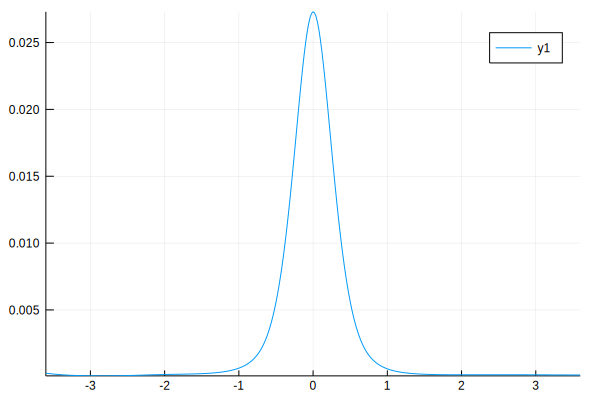

In [28]:
plot(brad_non_null.prior_grid, brad_non_null.g_prior)

In [29]:
x_grid = collect(linspace(-3,3,401))
post_mean_brad_null = [estimate(brad_null, PosteriorTarget(PosteriorMeanNumerator(x))) for x in x_grid];
post_mean_brad_non_null = [estimate(brad_non_null, PosteriorTarget(PosteriorMeanNumerator(x))) for x in x_grid];

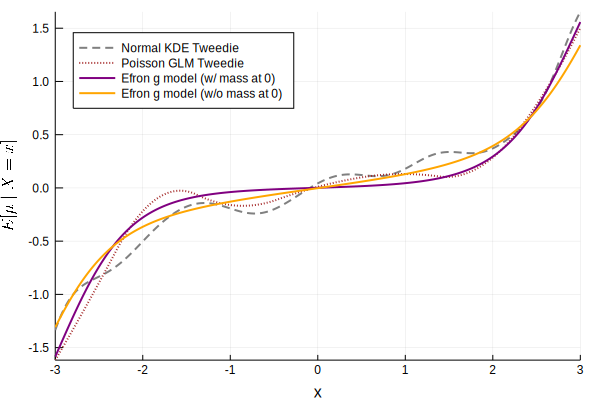

In [31]:
prostate_post_mean_gmodel = plot(x_grid,  [post_mean_bg tweedie_f post_mean_brad_null post_mean_brad_non_null] , linewidth=2,
        label =["Normal KDE Tweedie" "Poisson GLM Tweedie" "Efron g model (w/ mass at 0)" "Efron g model (w/o mass at 0)"],
        linestyle=[:dash :dot :solid :solid], color=[:grey :brown :purple :orange], legend=:topleft,
        xlabel="x", ylabel=L"E[\mu \mid X=x]")

In [32]:
savefig(prostate_post_mean_gmodel, "prostate_post_mean_gmodel.pdf")

In [33]:
x_grid2= collect(-4:0.1:4)
lfsr_brad = [estimate(brad_non_null, PosteriorTarget(LFSRNumerator(x))) for x in x_grid2];

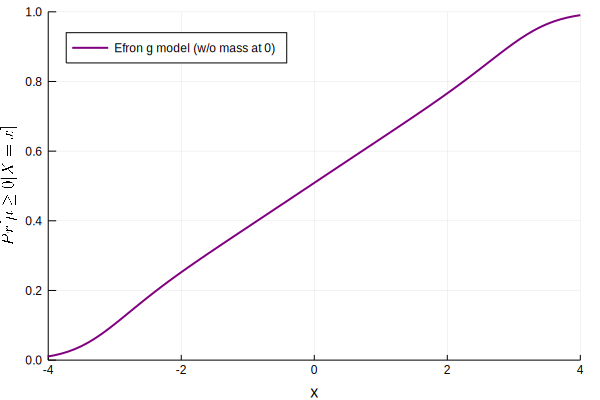

In [34]:
plot(x_grid2, lfsr_brad)
prostate_lfsr = plot(x_grid2,  [lfsr_brad] , linewidth=2, ylim=(0,1),
        label =["Efron g model (w/o mass at 0)"],
        linestyle=[:solid], color=[:purple], legend=:topleft,
        xlabel="x", ylabel=L"Pr[\mu \geq 0| X=x]")

In [35]:
savefig(prostate_lfsr,"prostate_lfsr.pdf",)

Construct the random splits for our CEB method:

In [36]:
srand(200)
Xs = prostz
n_total = length(Xs)
n_half = ceil(Int, n_total/2)
idx_test = sample(1:n_total, n_half, replace=false)
idx_train = setdiff(1:n_total, idx_test)
Xs_train = Xs[idx_train]
Xs_test = Xs[idx_test];

# Quick test 

In [37]:
target = PosteriorTarget(PosteriorMeanNumerator(1.0))

EmpiricalBayes.PosteriorTarget{EmpiricalBayes.PosteriorMeanNumerator}(EmpiricalBayes.PosteriorMeanNumerator(1.0), EmpiricalBayes.MarginalDensityTarget(1.0))

In [135]:
ceb_1 = CEB_ci(Xs_train, Xs_test, ds, PosteriorTarget(PosteriorMeanNumerator(4.0)))

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(EmpiricalBayes.DonohoCI(0.012481106158286456, 0.0042502541693487175, 2.9365552414007707, 2.549969504535929, 2.208649711557354, 2.891289297514504, 0.1308964565894454, 0.17353798534024262, EmpiricalBayes.BinnedMarginalDensity([1.18624e-5, 1.23739e-5, 1.28724e-5, 1.33571e-5, 1.38274e-5, 1.42827e-5, 1.47223e-5, 1.51457e-5, 1.55523e-5, 1.59415e-5  …  6.18662e-6, 6.78882e-6, 7.3854e-6, 7.97555e-6, 8.5585e-6, 9.13348e-6, 9.69972e-6, 1.02565e-5, 1.0803e-5, 1.13385e-5], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [0.00024777, 0.000255594, 0.000263615, 0.000271836, 0.000280259, 0.000288886, 0.000297722, 0.000306768, 0.000316026, 0.000325

In [137]:
ceb_1_flip = CEB_ci(Xs_test, Xs_train, ds, PosteriorTarget(PosteriorMeanNumerator(4.0)))

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(EmpiricalBayes.DonohoCI(0.012519955017944883, 0.004752261889323062, 2.6345254763996797, 2.462577070889634, 2.0669786898693268, 2.8581754519099416, 0.15311046645690668, 0.19933489555732187, EmpiricalBayes.BinnedMarginalDensity([1.27928e-5, 1.2426e-5, 1.20457e-5, 1.16521e-5, 1.12458e-5, 1.08273e-5, 1.03971e-5, 9.95548e-6, 9.50311e-6, 9.04046e-6  …  1.56257e-5, 1.5416e-5, 1.51892e-5, 1.49454e-5, 1.4685e-5, 1.44083e-5, 1.41156e-5, 1.38074e-5, 1.34839e-5, 1.31456e-5], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [-7.50603e-5, -7.84013e-5, -8.18793e-5, -8.54993e-5, -8.92667e-5, -9.31868e-5, -9.72652e-5, -0.000101507, -0.00010592, -0.0

In [136]:
ceb_1[1].ci_left, ceb_1[1].ci_right

(2.208649711557354, 2.891289297514504)

In [138]:
ceb_1_flip[1].ci_left, ceb_1_flip[1].ci_right

(2.0669786898693268, 2.8581754519099416)

In [23]:
ceb_1_cb = CEB_ci_cb(Xs_train, Xs_test, ds, PosteriorTarget(PosteriorMeanNumerator(1.0)),0.0015)

Academic license - for non-commercial use only


(EmpiricalBayes.DonohoCI(0.03773244879914656, 0.23669593809279443, 0.15941316569764669, 0.10306103953641763, 0.04142832239718714, 0.16469375667564812, 0.03181680687214747, 0.019897285572939672, EmpiricalBayes.BinnedMarginalDensity([1.18624e-5, 1.23739e-5, 1.28724e-5, 1.33571e-5, 1.38274e-5, 1.42827e-5, 1.47223e-5, 1.51457e-5, 1.55523e-5, 1.59415e-5  …  6.18662e-6, 6.78882e-6, 7.3854e-6, 7.97555e-6, 8.5585e-6, 9.13348e-6, 9.69972e-6, 1.02565e-5, 1.0803e-5, 1.13385e-5], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [0.000744919, 0.000763595, 0.000782437, 0.00080143, 0.000820553, 0.000839786, 0.000859107, 0.000878492, 0.000897916, 0.

In [21]:
ceb_1[1].ci_left, ceb_1[1].ci_right

(0.04127219369491319, 0.16353112179662493)

In [24]:
ceb_1_cb[1].ci_left, ceb_1_cb[1].ci_right

(0.04142832239718714, 0.16469375667564812)

In [17]:
ceb_1[4].C_bias, ceb_1[4].C_std

(0.0014706493989166533, 0.009680832664619277)

# Posterior Mean plots

## Comte Butucea pilot

In [38]:
xs = Float64.(collect(-3:0.25:3));

In [60]:
post_mean_nb_cb = [CEB_ci_cb(Xs_train, Xs_test, ds, PosteriorTarget(PosteriorMeanNumerator(x)), 0.0015) for x in xs];

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [61]:
save("prostate_post_mean_nb_cb.jld", "post_mean_nb_cb", post_mean_nb_cb)

In [68]:
left_ci_post_mean_nb_cb = [t[1].ci_left for t in post_mean_nb_cb]
right_ci_post_mean_nb_cb = [t[1].ci_right for t in post_mean_nb_cb]
point_est_post_mean_nb_cb = [t[1].calibrated_target for t in post_mean_nb_cb];

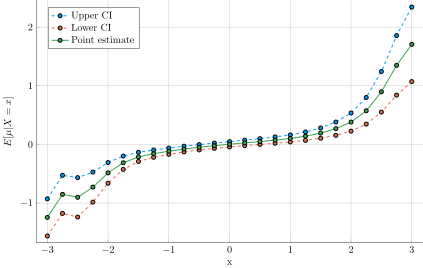

In [70]:
Plots.plot(xs, [right_ci_post_mean_nb_cb left_ci_post_mean_nb_cb point_est_post_mean_nb_cb],
     marker=([:hex :d]), label=["Upper CI" "Lower CI" "Point estimate"], 
     line=([:dash :dash :solid ]), xlabel="x", ylabel=L"E[\mu | X=x]",
     legend=:topleft)

## Calibrator pilot

In [64]:
post_mean_nb = [CEB_ci(Xs_train, Xs_test, ds, PosteriorTarget(PosteriorMeanNumerator(x))) for x in xs];

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [65]:
save("prostate_post_mean_nb.jld", "post_mean_nb", post_mean_nb)

In [39]:
post_mean_nb = load("prostate_post_mean_nb.jld")["post_mean_nb"];

In [41]:
left_ci_post_mean_nb = [t[1].ci_left for t in post_mean_nb]
right_ci_post_mean_nb  = [t[1].ci_right for t in post_mean_nb]
point_est_post_mean_nb = [t[1].calibrated_target for t in post_mean_nb];
max_bias_post_mean_nb = [t[1].max_bias for t in post_mean_nb]
se_post_mean_nb  = [t[1].std for t in post_mean_nb];

In [42]:
post_mean_brad_xs = [estimate(brad_null, PosteriorTarget(PosteriorMeanNumerator(x))) for x in xs];

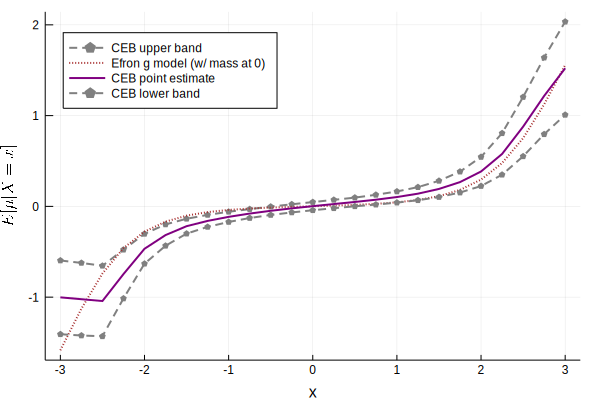

In [43]:
prostate_post_mean_bands = Plots.plot(xs, [right_ci_post_mean_nb post_mean_brad_xs point_est_post_mean_nb  left_ci_post_mean_nb],
     label=["CEB upper band"  "Efron g model (w/ mass at 0)" "CEB point estimate" "CEB lower band"], 
     markershape=[:pentagon :none :none :pentagon],
     markersize=3.5, markerstrokealpha=0, color=[:grey :brown :purple :grey], linewidth=2,
     line=([:dash :dot :solid :dash]), xlabel="x", ylabel=L"E[\mu | X=x]",
     legend=:topleft)


In [44]:
savefig(prostate_post_mean_bands, "prostate_post_mean_bands.pdf")

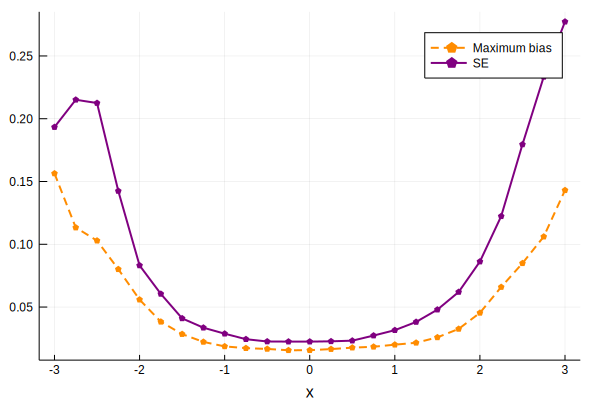

In [45]:
prostate_post_mean_bias_var = Plots.plot(xs, [max_bias_post_mean_nb  se_post_mean_nb],
     label=["Maximum bias" "SE"], 
     markershape=[:pentagon :pentagon],
     markersize=3.5, markerstrokealpha=0, color=[:darkorange :purple], linewidth=2,
     line=([:dash :solid]), xlabel="x")

In [46]:
savefig(prostate_post_mean_bias_var, "prostate_post_mean_bias_var.pdf")

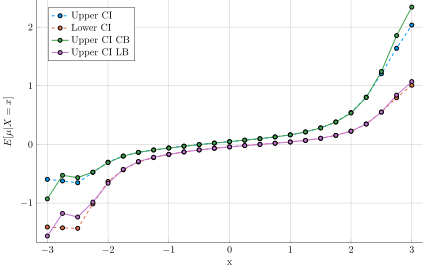

In [75]:
Plots.plot(xs, [right_ci_post_mean_nb left_ci_post_mean_nb right_ci_post_mean_nb_cb left_ci_post_mean_nb_cb],
     marker=([:hex :d]), label=["Upper CI" "Lower CI" "Upper CI CB" "Upper CI LB"], 
     line=([:dash :dash :solid :solid]), xlabel="x", ylabel=L"E[\mu | X=x]",
     legend=:topleft)

# LFSR bands

## CB

In [62]:
lfsr_nb_cb = [CEB_ci_cb(Xs_train, Xs_test, ds, PosteriorTarget(LFSRNumerator(x)), 0.0015) for x in xs];

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [63]:
save("prostate_lfsr_nb_cb.jld", "lfsr_nb_cb", lfsr_nb_cb)

In [100]:
left_ci_lfsr_nb_cb = [t[1].ci_left for t in lfsr_nb_cb]
right_ci_lfsr_nb_cb  = [t[1].ci_right for t in lfsr_nb_cb]
point_est_lfsr_nb_cb = [t[1].calibrated_target for t in lfsr_nb_cb];

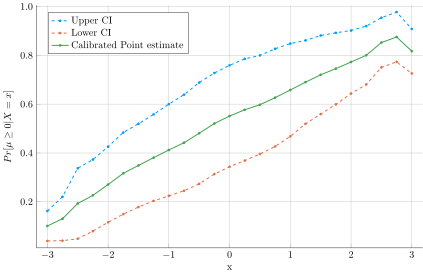

In [101]:
Plots.plot(xs, [right_ci_lfsr_nb_cb left_ci_lfsr_nb_cb point_est_lfsr_nb_cb],
     label=["Upper CI" "Lower CI" "Calibrated Point estimate"], markershape=[:pentagon :pentagon :pentagon],
     markersize=3, markerstrokealpha=0, 
     line=([:dash :dash :solid ]), xlabel="x", ylabel=L"Pr[\mu \geq 0| X=x]",
     legend=:topleft)

## Calibrator pilot

In [66]:
lfsr_nb = [CEB_ci(Xs_train, Xs_test, ds, PosteriorTarget(LFSRNumerator(x))) for x in xs];

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [47]:
xs_extrm = [collect(-4:0.25:-3.25); collect(3.25:0.25:4)];

In [ ]:
lfsr_nb = [CEB_ci(Xs_train, Xs_test, ds, PosteriorTarget(LFSRNumerator(x))) for x in xs];

In [152]:
lfsr_nb_extrm = [CEB_ci(Xs_train, Xs_test, ds, PosteriorTarget(LFSRNumerator(x))) for x in xs_extrm];

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [67]:
save("prostate_lfsr_nb.jld", "lfsr_nb", lfsr_nb)

In [48]:
lfsr_nb = load("prostate_lfsr_nb.jld")["lfsr_nb"];

In [153]:
save("prostate_lfsr_nb_extrm.jld", "lfsr_nb_extrm", lfsr_nb_extrm)

In [49]:
lfsr_nb_extrm = load("prostate_lfsr_nb_extrm.jld")["lfsr_nb_extrm"];

In [84]:
left_ci_lfsr_nb = [t[1].ci_left for t in lfsr_nb]
right_ci_lfsr_nb  = [t[1].ci_right for t in lfsr_nb]
point_est_lfsr_nb = [t[1].calibrated_target for t in lfsr_nb];

max_bias_lfsr_nb = [t[1].max_bias for t in lfsr_nb];
se_lfsr_nb = [t[1].std for t in lfsr_nb];

In [53]:
left_ci_lfsr_nb_extrm = [t[1].ci_left for t in lfsr_nb_extrm]
right_ci_lfsr_nb_extrm  = [t[1].ci_right for t in lfsr_nb_extrm]
point_est_lfsr_nb_extrm = [t[1].calibrated_target for t in lfsr_nb_extrm];

max_bias_lfsr_nb_extrm  = [t[1].max_bias for t in lfsr_nb_extrm]
se_lfsr_nb_extrm = [t[1].std for t in lfsr_nb_extrm];

In [54]:
left_ci_lfsr_nb = [left_ci_lfsr_nb_extrm[1:4]; left_ci_lfsr_nb; left_ci_lfsr_nb_extrm[5:8]]
right_ci_lfsr_nb = [right_ci_lfsr_nb_extrm[1:4]; right_ci_lfsr_nb; right_ci_lfsr_nb_extrm[5:8]]
point_est_lfsr_nb = [point_est_lfsr_nb_extrm[1:4]; point_est_lfsr_nb; point_est_lfsr_nb_extrm[5:8]];

max_bias_lfsr_nb = [max_bias_lfsr_nb_extrm[1:4]; max_bias_lfsr_nb; max_bias_lfsr_nb_extrm[5:8]];
se_lfsr_nb = [se_lfsr_nb_extrm[1:4]; se_lfsr_nb; se_lfsr_nb_extrm[5:8]];

xs_full = collect(-4:0.25:4);

In [55]:
lfsr_brad2 = [estimate(brad_non_null, PosteriorTarget(LFSRNumerator(x))) for x in xs_full];

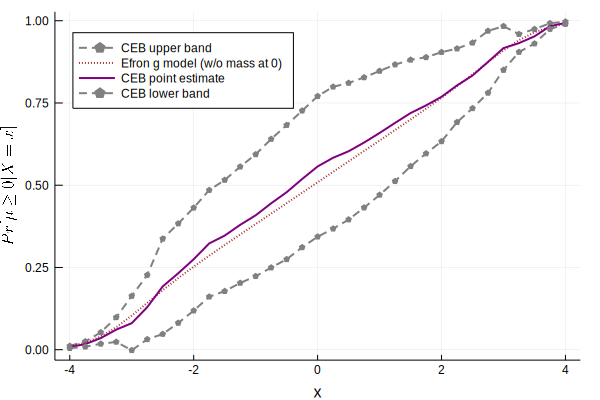

In [56]:
prostate_lfsr_bands = Plots.plot(xs_full, [right_ci_lfsr_nb lfsr_brad2 point_est_lfsr_nb  left_ci_lfsr_nb],
     label=["CEB upper band"  "Efron g model (w/o mass at 0)" "CEB point estimate" "CEB lower band"], 
     markershape=[:pentagon :none :none :pentagon],
     markersize=3.5, markerstrokealpha=0, color=[:grey :brown :purple :grey], linewidth=2,
     line=([:dash :dot :solid :dash]), xlabel="x",ylabel=L"Pr[\mu \geq 0| X=x]",
     legend=:topleft)

In [57]:
savefig(prostate_lfsr_bands,"prostate_lfsr_bands.pdf")

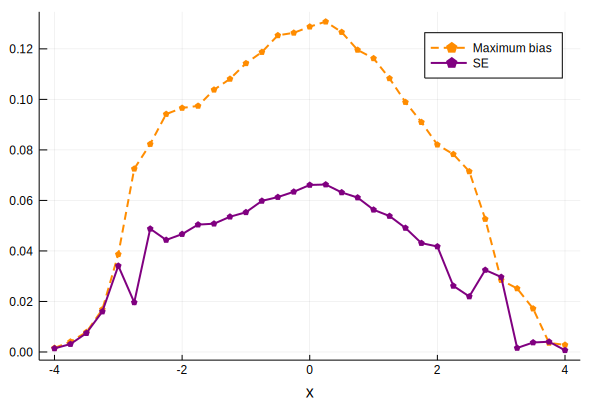

In [61]:
prostate_lfsr_bias_var = Plots.plot(xs_full, [max_bias_lfsr_nb  se_lfsr_nb],
     label=["Maximum bias" "SE"], 
     markershape=[:pentagon :pentagon],
     markersize=3.5, markerstrokealpha=0, color=[:darkorange :purple], linewidth=2,
     line=([:dash :solid]), xlabel="x")

In [62]:
savefig(prostate_lfsr_bias_var, "prostate_lfsr_bias_var.pdf")

## Actually let us rerun the above but with larger prior variance

In [74]:
std(Xs), sqrt(0.2^2+1), sqrt(0.3^2+1), sqrt(0.5^2+1) #kind of unreasonable but..

(1.1351290243788306, 1.019803902718557, 1.044030650891055, 1.118033988749895)

In [67]:
lfsr_nb_0_5 = [CEB_ci(Xs_train, Xs_test, ds_0_5, PosteriorTarget(LFSRNumerator(x))) for x in xs];

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


LoadError: [91mAdding range constraints not supported yet.[39m

In [75]:
lfsr_nb_0_3 = [CEB_ci(Xs_train, Xs_test, ds_0_3, PosteriorTarget(LFSRNumerator(x))) for x in xs];

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [76]:
save("prostate_lfsr_nb_0_3.jld", "lfsr_nb_0_3", lfsr_nb_0_3)

In [79]:
left_ci_lfsr_nb_0_3 = [t[1].ci_left for t in lfsr_nb_0_3]
right_ci_lfsr_nb_0_3  = [t[1].ci_right for t in lfsr_nb_0_3]
point_est_lfsr_nb_0_3 = [t[1].calibrated_target for t in lfsr_nb_0_3];

max_bias_lfsr_nb_0_3 = [t[1].max_bias for t in lfsr_nb_0_3];
se_lfsr_nb_0_3 = [t[1].std for t in lfsr_nb_0_3];

In [81]:
lfsr_brad_0_3 = [estimate(brad_non_null, PosteriorTarget(LFSRNumerator(x))) for x in xs];

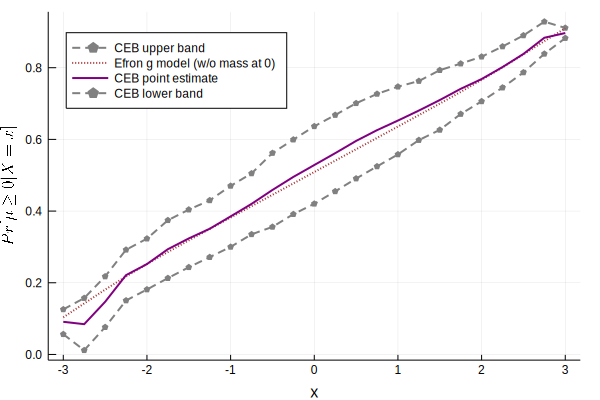

In [82]:
prostate_lfsr_0_3_bands = Plots.plot(xs, [right_ci_lfsr_nb_0_3 lfsr_brad_0_3 point_est_lfsr_nb_0_3  left_ci_lfsr_nb_0_3],
     label=["CEB upper band"  "Efron g model (w/o mass at 0)" "CEB point estimate" "CEB lower band"], 
     markershape=[:pentagon :none :none :pentagon],
     markersize=3.5, markerstrokealpha=0, color=[:grey :brown :purple :grey], linewidth=2,
     line=([:dash :dot :solid :dash]), xlabel="x",ylabel=L"Pr[\mu \geq 0| X=x]",
     legend=:topleft)

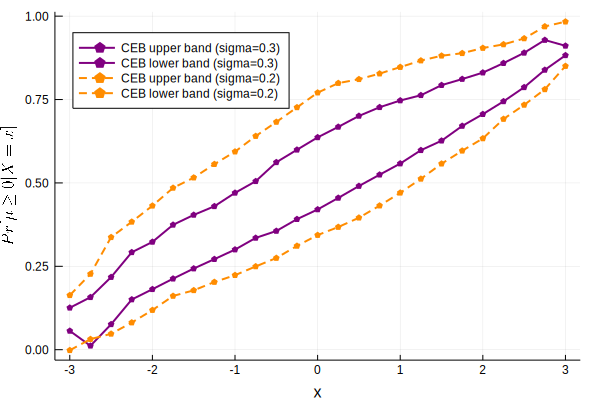

In [87]:
prostate_lfsr_0_2_vs_0_3_bands = Plots.plot(xs, [right_ci_lfsr_nb_0_3   left_ci_lfsr_nb_0_3 right_ci_lfsr_nb   left_ci_lfsr_nb],
     label=["CEB upper band (sigma=0.3)" "CEB lower band (sigma=0.3)" "CEB upper band (sigma=0.2)" "CEB lower band (sigma=0.2)"], 
     markershape=[:pentagon :pentagon :pentagon :pentagon],
     markersize=3.5, markerstrokealpha=0, color=[:purple :purple :darkorange :darkorange], linewidth=2,
     line=([:solid :solid :dash :dash]), xlabel="x",ylabel=L"Pr[\mu \geq 0| X=x]",
     legend=:topleft)

In [88]:
savefig(prostate_lfsr_0_2_vs_0_3_bands,"prostate_lfsr_0_2_vs_0_3_bands.pdf")

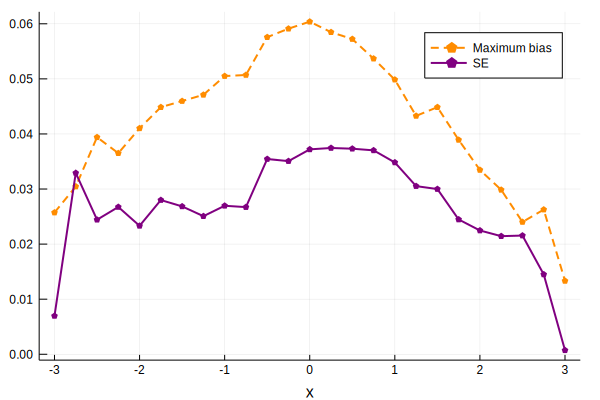

In [83]:
prostate_lfsr_0_3_bias_var = Plots.plot(xs, [max_bias_lfsr_nb_0_3  se_lfsr_nb_0_3],
     label=["Maximum bias" "SE"], 
     markershape=[:pentagon :pentagon],
     markersize=3.5, markerstrokealpha=0, color=[:darkorange :purple], linewidth=2,
     line=([:dash :solid]), xlabel="x")


In [55]:
ceb_lfsr = CEB_ci(Xs_train, Xs_test, ds, PosteriorTarget(LFSRNumerator(1.5)))

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(EmpiricalBayes.DonohoCI(0.0938416020166676, 0.13886362130771052, 0.6757824773179595, 0.7201542885333384, 0.5571342331294565, 0.8831743439372203, 0.050003199039863215, 0.09893835437115314, EmpiricalBayes.BinnedMarginalDensity([1.18624e-5, 1.23739e-5, 1.28724e-5, 1.33571e-5, 1.38274e-5, 1.42827e-5, 1.47223e-5, 1.51457e-5, 1.55523e-5, 1.59415e-5  …  6.18662e-6, 6.78882e-6, 7.3854e-6, 7.97555e-6, 8.5585e-6, 9.13348e-6, 9.69972e-6, 1.02565e-5, 1.0803e-5, 1.13385e-5], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [-0.00367364, -0.00384251, -0.00401855, -0.00420203, -0.00439325, -0.00459248, -0.00480005, -0.00501625, -0.00524142, -0.005

In [56]:
ceb_lfsr_cb = CEB_ci_cb(Xs_train, Xs_test, ds, PosteriorTarget(LFSRNumerator(1.5)), 0.0015)

Academic license - for non-commercial use only


(EmpiricalBayes.DonohoCI(0.10440730392308291, 0.13994427794525582, 0.7460634007767402, 0.7174177636715627, 0.5552799132142253, 0.8795556141289002, 0.04746183018516701, 0.10131306383463379, EmpiricalBayes.BinnedMarginalDensity([1.18624e-5, 1.23739e-5, 1.28724e-5, 1.33571e-5, 1.38274e-5, 1.42827e-5, 1.47223e-5, 1.51457e-5, 1.55523e-5, 1.59415e-5  …  6.18662e-6, 6.78882e-6, 7.3854e-6, 7.97555e-6, 8.5585e-6, 9.13348e-6, 9.69972e-6, 1.02565e-5, 1.0803e-5, 1.13385e-5], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [-0.00158964, -0.00168215, -0.00177938, -0.00188154, -0.00198884, -0.00210153, -0.00221983, -0.00234398, -0.00247425, -0.002

In [57]:
ceb_lfsr[1].ci_left, ceb_lfsr[1].ci_right, ceb_lfsr[1].est_target, ceb_lfsr[1].est_denom, ceb_lfsr[1].est_num

(0.5571342331294565, 0.8831743439372203, 0.6757824773179595, 0.13886362130771052, 0.0938416020166676)

In [58]:
ceb_lfsr_cb[1].ci_left, ceb_lfsr_cb[1].ci_right, ceb_lfsr_cb[1].est_target, ceb_lfsr_cb[1].est_denom, ceb_lfsr_cb[1].est_num

(0.5552799132142253, 0.8795556141289002, 0.7460634007767402, 0.13994427794525582, 0.10440730392308291)

In [59]:
ceb_lfsr_cb[1].calibrated_target, ceb_lfsr[1].calibrated_target

(0.7174177636715627, 0.7201542885333384)

In [ ]:
lfsr_nb_cb = [CEB_ci_cb(Xs_train, Xs_test, ds, PosteriorTarget(LFSRNumerator(x)), 0.0015) for x in xs];

In [13]:
tst_fit = donoho_test2(Xs_train, Xs_test, f_kde,
            ds,  PosteriorTarget(PosteriorMeanNumerator(2.0)); ε=1e-5, C=0.2)

(EmpiricalBayes.DonohoCI(0.014590362682100516, 0.06371134209247553, 0.22900730392593116, 0.2964597701976685, 0.09705079225886556, 0.4958687481364714, 0.11484166985363839, 0.03879302690609081, EmpiricalBayes.BinnedMarginalDensity([1.03495e-8, 8.27502e-9, 6.59196e-9, 5.23184e-9, 4.13703e-9, 3.25925e-9, 2.55824e-9, 2.00059e-9, 1.55873e-9, 1.20997e-9  …  7.90873e-8, 6.56163e-8, 5.4239e-8, 4.4669e-8, 3.66519e-8, 2.99626e-8, 2.44039e-8, 1.9803e-8, 1.60103e-8, 1.28962e-8], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [-0.0392186, -0.0405866, -0.0419948, -0.043444, -0.0449351, -0.0464691, -0.0480467, -0.0496688, -0.0513363, -0.05305  …  

In [17]:
tst_fit[1].ci_left, tst_fit[1].ci_right

(0.09705079225886556, 0.4958687481364714)

In [32]:
tst_fit_002[1].ci_left, tst_fit_002[1].ci_right

(0.28356262934776455, 0.564685926286587)

In [72]:
tst_fit_calib[1].ci_left, tst_fit_calib[1].ci_right

(0.25720961933009545, 0.5723153768117845)

In [23]:
tst_fit_002_npmle[1].ci_left, tst_fit_002_npmle[1].ci_right

(0.14808734200592993, 0.5266332186349183)

In [35]:
tst_fit_Inf[1].ci_left, tst_fit_Inf[1].ci_right

(0.10157576736205454, 0.5007554740981148)

In [71]:
tst_fit_calib = donoho_test2(Xs_train, Xs_test, f_kde3,
            ds,  PosteriorTarget(PosteriorMeanNumerator(2.0)); ε=1e-5, C=C_sd_b)

(EmpiricalBayes.DonohoCI(0.02110709031500792, 0.0633644848734702, 0.33310600342061897, 0.41476249807093996, 0.25720961933009545, 0.5723153768117845, 0.0872965610388828, 0.03941050068457138, EmpiricalBayes.BinnedMarginalDensity([1.18624e-5, 1.23739e-5, 1.28724e-5, 1.33571e-5, 1.38274e-5, 1.42827e-5, 1.47223e-5, 1.51457e-5, 1.55523e-5, 1.59415e-5  …  6.18662e-6, 6.78882e-6, 7.3854e-6, 7.97555e-6, 8.5585e-6, 9.13348e-6, 9.69972e-6, 1.02565e-5, 1.0803e-5, 1.13385e-5], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [-0.0390156, -0.0385726, -0.0382315, -0.037982, -0.037816, -0.0377266, -0.0377086, -0.0377573, -0.0378692, -0.0380414  …  -

In [33]:
tst_fit_Inf = donoho_test2(Xs_train, Xs_test, f_kde,
            ds,  PosteriorTarget(PosteriorMeanNumerator(2.0)); ε=1e-5, C=Inf)

(EmpiricalBayes.DonohoCI(0.015327709843749926, 0.0634529057904357, 0.241560408507884, 0.3011656207300847, 0.10157576736205454, 0.5007554740981148, 0.11532902137359209, 0.037677386570240855, EmpiricalBayes.BinnedMarginalDensity([1.03495e-8, 8.27502e-9, 6.59196e-9, 5.23184e-9, 4.13703e-9, 3.25925e-9, 2.55824e-9, 2.00059e-9, 1.55873e-9, 1.20997e-9  …  7.90873e-8, 6.56163e-8, 5.4239e-8, 4.4669e-8, 3.66519e-8, 2.99626e-8, 2.44039e-8, 1.9803e-8, 1.60103e-8, 1.28962e-8], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [-0.039866, -0.0412397, -0.042653, -0.0441066, -0.0456015, -0.0471384, -0.0487181, -0.0503414, -0.0520092, -0.0537222  …  1

In [30]:
tst_fit_002 = donoho_test2(Xs_train, Xs_test, f_kde,
            ds,  PosteriorTarget(PosteriorMeanNumerator(2.0)); ε=1e-5, C=0.02)

(EmpiricalBayes.DonohoCI(0.022942354422702385, 0.06564790585094772, 0.3494758001084231, 0.42412427781717577, 0.28356262934776455, 0.564685926286587, 0.07469809123220347, 0.04160692689906706, EmpiricalBayes.BinnedMarginalDensity([1.03495e-8, 8.27502e-9, 6.59196e-9, 5.23184e-9, 4.13703e-9, 3.25925e-9, 2.55824e-9, 2.00059e-9, 1.55873e-9, 1.20997e-9  …  7.90873e-8, 6.56163e-8, 5.4239e-8, 4.4669e-8, 3.66519e-8, 2.99626e-8, 2.44039e-8, 1.9803e-8, 1.60103e-8, 1.28962e-8], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [0.00164169, 0.00172733, 0.00181716, 0.00191137, 0.00201016, 0.00211372, 0.00222228, 0.00233606, 0.00245529, 0.0025802  … 

In [ ]:
load("")

In [20]:
xs

LoadError: [91mUndefVarError: xs not defined[39m

In [7]:
tst = donoho_test2(Xs_train, Xs_test, f_const,
            ds, target; ε=M_bd)


(EmpiricalBayes.DonohoCI(0.035188243621098056, 0.2370617016655272, 0.14843495754006486, 0.13397413681912723, 0.04118372505807004, 0.2267645485801844, 0.0473827448260883, 0.030819271344263394, EmpiricalBayes.BinnedMarginalDensity([0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731  …  0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [0.000594283, 0.000613689, 0.000633604, 0.000654036, 0.000674991, 0.000696478, 0.000718503, 0.000741074, 0.000764197, 

In [21]:
xs = Float64.(collect(-4:1:4))

9-element Array{Float64,1}:
 -4.0
 -3.0
 -2.0
 -1.0
  0.0
  1.0
  2.0
  3.0
  4.0

In [14]:
myres = [donoho_test2(Xs_train, Xs_test, f_const,
            ds, PosteriorTarget(PosteriorMeanNumerator(x)); ε=M_bd) for x in xs]

9-element Array{Tuple{EmpiricalBayes.DonohoCI,EmpiricalBayes.MinimaxCalibrator,EmpiricalBayes.MinimaxCalibrator},1}:
 (EmpiricalBayes.DonohoCI(-0.0175609, 0.00581475, -3.02007, -2.6577, -4.14479, -1.17062, 0.357049, 1.02951, EmpiricalBayes.BinnedMarginalDensity([0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731  …  0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.012), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.012, [-0.0357925, -0.0369163, -0.0380691, -0.0392515, -0.040464, -0.041707, -0.0429812, -0.044287, -0.0456249, -0.046995

In [35]:
save("prostate_post_mean.jld", "myres", myres)


In [36]:
custom_target(u) = PosteriorTarget(GeneralPosteriorLinearTarget(x->abs(x)>=1.5, u))

custom_target (generic function with 1 method)

In [37]:
custom_target(1.0)

EmpiricalBayes.PosteriorTarget(EmpiricalBayes.GeneralPosteriorLinearTarget(#17, 1.0), EmpiricalBayes.MarginalDensityTarget(1.0))

In [173]:
struct PosteriorTwoSidedTailNumerator <: EmpiricalBayes.PosteriorNumeratorTarget
    x::Float64
    cutoff::Float64
end

function riesz_representer(target::PosteriorTwoSidedTailNumerator, t)
    pdf(Normal(), target.x - t)*(abs(t)>=target.cutoff)
end

riesz_representer (generic function with 6 methods)

In [174]:
xs_new = collect(-4:0.5:4)
post_prob_nb = [CEB_ci(Xs_train, Xs_test, ds, PosteriorTarget(PosteriorTwoSidedTailNumerator(x, 1.5))) for x in xs_new];

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [175]:
save("prostate_post_prob_nb.jld", "post_prob_nb", post_prob_nb)

In [38]:
myres2 = [donoho_test2(Xs_train, Xs_test, f_const,
            ds, custom_target(x); ε=M_bd) for x in xs]

9-element Array{Tuple{EmpiricalBayes.DonohoCI,EmpiricalBayes.MinimaxCalibrator,EmpiricalBayes.MinimaxCalibrator},1}:
 (EmpiricalBayes.DonohoCI(0.00639336, 0.00581475, 1.09951, 1.36827, 0.869965, 1.86658, 0.114968, 0.350973, EmpiricalBayes.BinnedMarginalDensity([0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731  …  0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.012), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.012, [-0.00293645, -0.00304075, -0.00314827, -0.00325908, -0.00337328, -0.00349094, -0.00361214, -0.00373697, -0.00386551

In [50]:
lower_ci = [t[1].ci_left for t in myres2]
right_ci = [t[1].ci_right for t in myres2]
#lower_ci = max.(0, lower_ci)
#right_ci = min.(1, right_ci)
point_est = max.( 0 , min.(1,[t[1].calibrated_target for t in myres2]))

9-element Array{Float64,1}:
 1.0       
 0.593595  
 0.00710872
 0.0       
 0.0       
 0.0       
 0.0       
 0.682953  
 1.0       


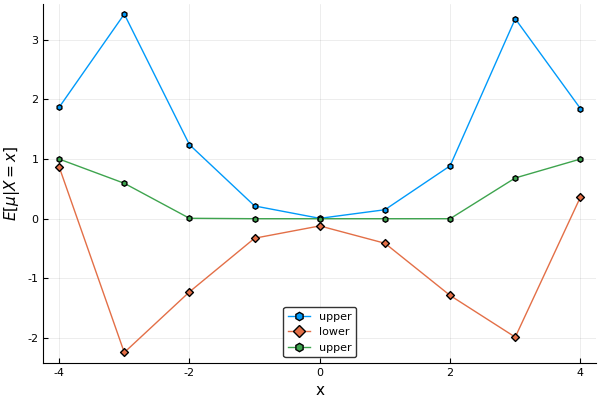

In [51]:
plot(xs, [right_ci lower_ci point_est],marker=([:hex :d]), label=[:upper :lower], xlabel="x", ylabel=L"E[\mu | X=x]")


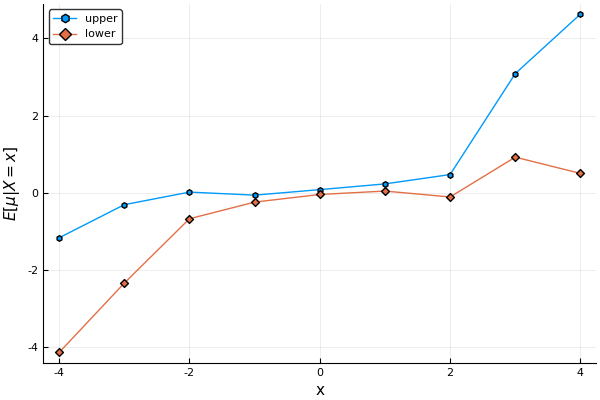

In [33]:
plot(xs, [right_ci lower_ci],marker=([:hex :d]), label=[:upper :lower], xlabel="x", ylabel=L"E[\mu | X=x]")

In [8]:
tst[1].ci_left, tst[1].ci_right

(0.04118372505807004, 0.2267645485801844)

In [18]:
tst[1].calibrated_target

-44.26765871605007

In [14]:
tst[1].est_num/tst[1].est_denom

3.458441636314199

In [32]:
length(unique(idx_test))

3017

In [68]:
M_max_num = MinimaxCalibrator(ds, f_const, length(Xs_train), PosteriorMeanNumerator(4.0);
                tol=1e-4, ε=M_bd, C=Inf);

In [69]:
num_res = donoho_ci(Xs_train, M_max_num; conf=0.9) #efron: 0.048-0.076

(0.012643908094895365, -0.006566367878011275, 0.03185418406780201)

In [70]:
M_max_denom = MinimaxCalibrator(ds, f_const, length(Xs_train), MarginalDensityTarget(4.0);
                tol=1e-4, ε=M_bd, C=Inf);

In [71]:
denom_res = donoho_ci(Xs_train, M_max_denom; conf=0.9) #efron: 0.048-0.076

(0.004187042917557218, 0.00019132366671182743, 0.008182762168402608)

In [72]:
num_res./denom_res[1]

(3.0197703591421523, -1.568259033237278, 7.607799751521584)

In [73]:
est_init = num_res[1]/denom_res[1]

3.0197703591421523

In [3]:
target = PosteriorTarget(PosteriorMeanNumerator(4.0))
target.num

EmpiricalBayes.PosteriorMeanNumerator(4.0)

In [77]:
tst = donoho_test2(Xs_test, num_res[1], denom_res[1], f_const,
            ds, target)

EmpiricalBayes.DonohoCI(0.012643908094895365, 0.004187042917557218, 3.0197703591421523, 2.505755336663383, 0.46083122878919713, 4.550679444537569, EmpiricalBayes.BinnedMarginalDensity([0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731  …  0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731, 0.00478731], [-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567), EmpiricalBayes.MinimaxCalibrator(EmpiricalBayes.BinnedCalibrator([-6.0, -5.988, -5.976, -5.964, -5.952, -5.94, -5.928, -5.916, -5.904, -5.892  …  5.892, 5.904, 5.916, 5.928, 5.94, 5.952, 5.964, 5.976, 5.988, 6.0], 0.011999999999999567, [-0.00040289, -0.00041765, -0.000432896, -0.000448642, -0.000464902, -0.00048169, -0.000499021, -0.000516911, -0.000535375, -0.000554428  …  0.0469972, 0.0456265, 

In [66]:
donoho_ci(Xs_test, tst.ma; conf= 0.9)./denom_res[1]   .+ est_init

(2.017154419726449, 0.9382567773831607, 3.0960520620697363)

In [82]:
tst.calibrated_target, tst.ci_left, tst.ci_right

(2.505755336663383, 0.46083122878919713, 4.550679444537569)

In [83]:
tst.ma.max_bias/denom_res[1]

1.4284225869833327

In [84]:
tst.ma.sd/denom_res[1]

1.8194237773798345

In [85]:
std(tst.ma.(Xs))/sqrt(n_half)/denom_res[1]

0.48082316786685964

# Posterior expectation curves